In [10]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import math as maths
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from scipy.integrate import odeint
from scipy.optimize import minimize as minimise, curve_fit
from scipy.stats import ks_2samp

sns.set(style="white", color_codes=True)
sns.despine(trim = True)
sns.set_context('poster', font_scale = 1)
sns.set_palette("colorblind", 8) #sns colormap for graph


timespan = np.linspace(0,72,100)
sigma = np.random.random(100)*0.0001
sigma[0] = 100  #sets sigma value to very high for first data point, 
                #because this is the one fed into the model and therefore the one that must be fitted to.

# Testing 6 Parameter fitting algorithm

- tests parameter fitting by running 300 times on 300 sets of data simulated with the model, then comparing the actual parameters used to simulate the data with the parameters fitted to the data by the fitting algorithm.

In [2]:
def diffeq(y, t, k0, k1, k2, k3, k4, k5):

    ''' 
    Function containing the ODEs for the model system:
    inputs:
        y - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t - time over which the function runs (not necessary for the equation, but is for integration with odeint)
        k0, k1, k2, k3, k4, k5, k6 - float, parameter values
    '''

    SPCi = y[0]
    STMi = y[1]
    SLGCi = y[2]
    PCi = y[3]
    #the model equations =

    f0 = (k3*SLGCi) - ((k0+k1)*SPCi)
    f1 = (k0*SPCi)
    f2 = (k1*SPCi)+(k4*PCi)-((k2+k3)*SLGCi)
    f3 = (k2*SLGCi) + ((k5-k4)*PCi)

    return [f0, f1, f2, f3]

In [3]:
def diffeqsolver(y1, t1, parameters1):

    '''
    function which passes the input from func to odeint
    inputs:
        y1 - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t1 - time for diffeq solver
        parameters - list of parameters to be fed to diffeqs
    '''

    parameters_tuple = tuple(parameters1)

    soln = odeint(diffeq, y1, t1, args = parameters_tuple)
    MC = soln[:, 0]
    STM = soln[:, 1]
    SLGC = soln[:, 2]
    PC = soln[:, 3]

    return [MC, STM, SLGC, PC]


In [4]:
def param_fitter(cell_counts, initial_guess):
    '''
    function to pass data through scipy.minimize (here named minimise)
    input:
        - cell counts at t0
        - initial guess of parameter values
        
    output:
        - scipy.minimise object attribute .x, which is the minimised parameter values.
    '''

    def minimiserk7(params1):

        '''function to be minimised by the scipy minimiser.
        accepts only params, an array of the first guesses for each parameter.

        outputs the regression for the fit between a line of best fit and the model.'''

        xlist = cell_counts #cell type to be fitted to
        y1 = xlist[:, 0]

        y = diffeqsolver(y1, timespan, params1)
        minval = np.zeros(len(xlist))  
        for x in range(len(xlist)):
            
            curve = np.polyfit(timespan,xlist[x], 1) #fit cell counts from data to a curve
            x2 = np.polyval(curve, timespan) #evaluate curve over timecourse

            y0 = y[x] #values from integrated ode over time

            ss=lambda data,model:((data-model)**2).sum() #sum sq diff between data and guess
            minval[x] = ss(x2, y0)
            
        return minval.sum()
    
    solution = minimise(minimiserk7, initial_guess,
                        bounds = ((0, None),(0, None),(0, None),(0, None),(0, None),(0, None)))
    

    return solution.x


In [5]:
tries = 300
difference_list = np.empty([tries, 6])
int_diff_list = np.empty([tries, 6])

int_cells = np.random.rand(4)*0.01
actual_params = np.random.rand(6)*0.001


for go in range(0, tries):
    int_params = np.random.rand(6)*0.001
    
    cell_list = np.asarray(diffeqsolver(int_cells, timespan, actual_params))
    fitted_params = param_fitter(cell_list, int_params)
    difference = [((fitted_params[i]-actual_params[i])) for i in range(len(fitted_params))]
    int_difference = [((int_params[i]-actual_params[i])) for i in range(len(int_params))]
    difference_list[go] = difference
    int_diff_list[go] = int_difference
    print(go)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
guesspd = pd.DataFrame.from_dict(difference_list)
yes_list = [[ x  for x in guesspd[i] if 0.5 > x or x > 1.5 ] for i in range(0, 4)]
[len(yes_list[i]) for i in range(0,4)]

[300, 300, 300, 300]

In [7]:
intpd = pd.DataFrame.from_dict(int_diff_list)
intpd
yes_list = [[ x  for x in intpd[i] if x > 1 ] for i in range(0, 4)]
[len(yes_list[i]) for i in range(0,4)]

[0, 0, 0, 0]

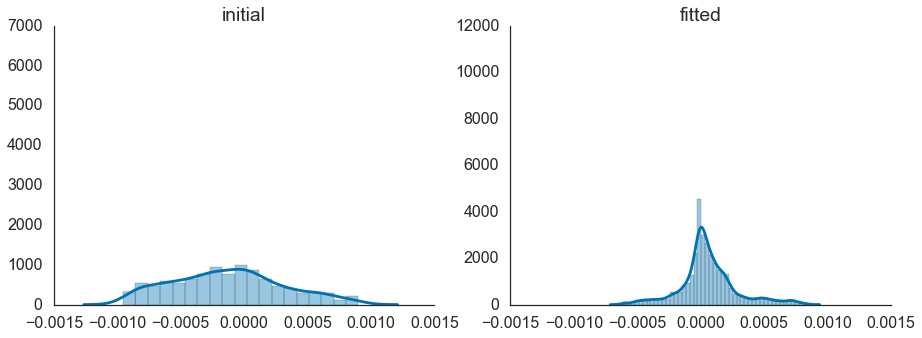

In [8]:

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.distplot(difference_list.flatten(), norm_hist = False, ax = ax2)
sns.distplot(int_diff_list.flatten(), norm_hist = False, ax = ax1)
ax1.set_title('initial')
ax2.set_title('fitted')
ax1.set_xlim(-0.0015, 0.0015)
ax1.set_ylim(0,7000)
ax2.set_xlim(-0.0015, 0.0015)
ax2.set_ylim(0,12000)
sns.despine() 
plt.savefig('KDE_plot_parameter_fit_NEW.svg')
plt.rcParams['svg.fonttype'] = 'none'

In [9]:
diff_val = difference_list.flatten()
int_val = int_diff_list.flatten()

ks_2samp(int_val, diff_val)

Ks_2sampResult(statistic=0.37666666666666665, pvalue=2.9828277913501779e-112)